In [1]:
from backend import *
from tqdm.notebook import tqdm
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from itertools import combinations
from random import sample
import matplotlib.pyplot as plt

# Preprocessing Earthquake probabilities

In [49]:
# Creating the DataFrame of the earthquakes' probabilities
#df = pd.read_table('../incremental_annual_rates/incremental_annual_rates_USA.txt', sep='\s+', header=None)
df = pd.read_table('/home/mogyi/Projects/FRADIR/PSRLG_JSAC2020_toMogyi/seismic_data/incremental_annual_rates/incremental_annual_rates_italy.txt', sep='\s+', header=None)

df.columns = ['Long', 'Lat'] + [str(np.around(x,1)) for x in np.arange(4.6, 8.2, 0.1)]
#df.drop(df.columns[42:], axis=1, inplace=True)
df.fillna(value=0.0, inplace=True)
df = df[df['4.6'] != 0.0]

#df.to_csv('incremental_annual_rates/incremental_annual_rates_italy_without_zeros.csv', index=False)

In [50]:
pd.options.display.float_format = '{:,.10f}'.format

In [51]:
df.head()

,Long,Lat,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,...,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1
1400,10.8000000000,48.3000000000,0.0000000006,0.0000000004,0.0000000003,0.0000000003,0.0000000002,0.0000000002,0.0000000001,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1401,10.8500000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1402,10.9000000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1403,10.9500000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000003,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1404,11.0000000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [ ]:
df = pd.read_csv('../incremental_annual_rates/incremental_annual_rates_USA.csv')
df.describe()

In [6]:
df = df[df['4.6'] != 0.0]

In [12]:
# Delete If no earthquake exist with such magnitude
df.drop(labels=['8.5', '8.6'], axis=1, inplace=True)

In [52]:
# Convert the rates to probabilities
prob_matrix = df.drop(['Lat', 'Long'], axis=1).to_numpy()
scale = prob_matrix.sum()
print(scale)
df.iloc[:,2:] = df.iloc[:,2:] / scale

#df.to_csv('earthquake_probabilities/italy_short.csv', index=False)

5.5384342731352865


In [53]:
df.to_csv('earthquake_probabilities/italy.csv', index=False)

In [54]:
len(df)

48442

In [97]:
df = pd.read_csv('earthquake_probabilities/italy.csv')

In [67]:
# Downsample the eartquakes
res = 10
ds = df.copy()
ds['Lat'] = (ds['Lat']*res).astype(int)
ds['Long'] = (ds['Long']*res).astype(int)
ds = ds.groupby(['Long','Lat'], as_index=False).sum()
ds['Lat'] = ds['Lat']/res
ds['Long'] = ds['Long']/res

print(f'Original number of eartquakes: {len(df)}')
print(f'Downsampled number of eartquakes: {len(ds)}')
print(f'Ratio: {len(df)/len(ds):.2f}')
ds.head()


Original number of eartquakes: 48442
Downsampled number of eartquakes: 12307
Ratio: 3.94


,Long,Lat,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,...,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1
0,5.0000000000,45.1000000000,0.0000000001,0.0000000001,0.0000000001,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,5.0000000000,45.2000000000,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,0.0000000001,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,5.0000000000,45.3000000000,0.0000000008,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,5.0000000000,45.4000000000,0.0000000009,0.0000000007,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,5.0000000000,45.5000000000,0.0000000009,0.0000000007,0.0000000006,0.0000000004,0.0000000004,0.0000000003,0.0000000002,0.0000000002,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [99]:
ds['4.6'].sum()

0.20025143023418376

In [100]:
df['4.6'].sum()

0.20025143023418376

In [43]:
ds.to_csv('earthquake_probabilities/italy_ds16.csv', index=False)

# Preprocessing the network

In [2]:
#g1 = nx.read_gml('networks/usa_995.gml', label='id')
g = read_lgf_to_networkx_extended('../spine/solution_janos-us_sndlib_long-lat_cost3_minAvailWPreq0-99500.lgf')

In [7]:
g.edges[(0, 8, 0)]

{'points': {'point': [{'Longitude': -77.04, 'Latitude': 38.85},
   {'Longitude': -81.68, 'Latitude': 41.52}]},
 'onspine': 1,
 'unav1': 0.0030015221,
 'unav': 0.001}

In [8]:
for e in g.edges:
    g.edges[e]['unav'] = g.edges[e]['unav1']

In [4]:
for e in g2.edges:
    pointA = g2.edges[e]['points']['point'][0]
    pointB = g2.edges[e]['points']['point'][-1]
    g2.edges[e]['length'] = distance((pointA['Latitude'], pointA['Longitude']), (pointB['Latitude'], pointB['Longitude'])).km

In [9]:
#nx.write_gml(g2, 'networks/usa_995.gml')
write_networkx_to_lgf(g, 'networks/usa_995_initial.lgf')

0

In [ ]:
EARTH_RADIUS = 6371

g = nx.read_gml('networks/interoute_v2_feri.gml', label='id')
edge = (2, 5, 0)

for n in g.nodes:
    u = node_to_SVector(g.nodes[n])
    v,w = edge_to_SVectors(g.edges[edge])
    gomb = int(u.distance_to_section(v,w) * EARTH_RADIUS)
    
    edge_points = [tuple(p.values()) for p in g.edges[edge]['points']['point']]
    l = LineString(edge_points)
    p = Point(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])
    nearest_point = nearest_points(l, p)[0].coords[0]
    R = distance(lonlat(*(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])), lonlat(*nearest_point)).km
    print(f'{(gomb-R)/(R+1):.2f}')

# Earthquake intensity calculation

In [15]:
g = nx.read_gml('networks/usa_995.gml', label='id')

df = pd.read_csv('earthquake_probabilities/usa_ds23.csv')
df.insert(loc=0, column='Epicenter', value=list(zip(df.Long, df.Lat)))
df.set_index('Epicenter', inplace=True)
df.drop(['Lat', 'Long'], axis=1, inplace=True)

epicenters = df.index
magnitudes = df.columns

In [16]:
epicenters[:2]

Index([(-124.5, 42.0), (-124.5, 42.5)], dtype='object', name='Epicenter')

In [17]:
EARTH_RADIUS = 6371
I1= np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))
I2 = np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))

D1 = np.ones((g.number_of_edges(), len(epicenters)))
D2 = np.ones((g.number_of_edges(), len(epicenters)))

for i, e in tqdm(enumerate(g.edges), total=g.number_of_edges()):
    edge_points = [(p['Longitude'], p['Latitude']) for p in g.edges[e]['points']['point']]
    l = LineString(edge_points)
    v,w = edge_to_SVectors(g.edges[e])
    for j, epicenter in enumerate(epicenters):
        p = Point(epicenter[0],epicenter[1])
        nearest_point = nearest_points(l, p)[0].coords[0]
        # print([o.wkt for o in nearest_points(l, p)])
        
        R1 = distance(lonlat(*epicenter), lonlat(*nearest_point)).km
        
        u = SVector(epicenter[1],epicenter[0])
        R2 = u.distance_to_section(v,w) * EARTH_RADIUS
        #print(i, e,R1, R2)
        
        D1[i,j] = R1
        D2[i,j] = R2


for k, M in enumerate(magnitudes):
    i1 = intensity_europe(np.float(M), D1)
    i1[i1<1.] = 1.
    i2 = intensity_europe(np.float(M), D2)
    i2[i2<1.] = 1.
    I1[:,:,k] = i1
    I2[:,:,k] = i2

In [32]:
I3 = np.ones((g.number_of_edges(), len(df.index), len(df.columns)))
for k, M in enumerate(df.columns):
    i = intensity_europe(np.float(M), D1-1.5)
    i[i<1.] = 1.
    I3[:,:,k] = i

(array([8.5000e+01, 1.6540e+03, 9.9894e+04, 3.5055e+04, 4.1900e+03,
        2.0240e+03, 1.2760e+03, 9.0600e+02, 6.6300e+02, 4.1300e+02,
        3.0000e+02, 2.0700e+02, 1.3100e+02, 1.0200e+02, 6.2000e+01,
        5.3000e+01, 3.6000e+01, 3.1000e+01, 2.8000e+01, 1.6000e+01]),
 array([-25.09311274, -15.19055418,  -5.28799562,   4.61456294,
         14.5171215 ,  24.41968006,  34.32223862,  44.22479718,
         54.12735574,  64.02991431,  73.93247287,  83.83503143,
         93.73758999, 103.64014855, 113.54270711, 123.44526567,
        133.34782423, 143.25038279, 153.15294136, 163.05549992,
        172.95805848]),
 <BarContainer object of 20 artists>)

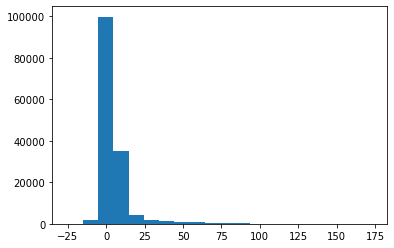

In [18]:
import matplotlib.pyplot as plt

diff = ((D1 - D2)).flatten()

plt.hist(diff, 20)

In [32]:
np.save('intensities/usa_ds23.npy', I1)
#np.save('intensities/italy_ds16_csak.npy', I2)

# SRLG collection

In [11]:
g = nx.read_gml('networks/italy_995.gml', label="id")
min_cut_srlgs = get_minimal_cut_SRLGs('PSRLGs/italy_995.xml', g)
len(min_cut_srlgs)

356

In [16]:
H = np.array([6+0*g.edges[e]['onspine'] for e in g.edges])
print(get_probability_of_falling_apart(min_cut_srlgs,g,I1,H,prob_matrix))
min_cut_srlgs_short = [srlg for srlg in min_cut_srlgs if get_SRLG_probability(srlg,g,I1,H,prob_matrix) > 0.00018]
print(len(min_cut_srlgs_short))
print(get_probability_of_falling_apart(min_cut_srlgs_short,g,I1,H,prob_matrix))

0.022360473108439742
45
0.022135238966453235


In [3]:
len(srlgs)

11929

In [ ]:
 for srlg in srlgs:
    print(get_SRLG_probability(srlg,g,I1,H,prob_matrix), srlg)
#print(get_probability_of_falling_apart(srlgs,g,I1,H,prob_matrix))

In [2]:
# The network
network = 'italy_995'

g = nx.read_gml(f'networks/{network}.gml', label="id")
L = len(g.edges)
links = range(L)

# The matrix of the intensity values, dimensions: [L,P,M] (link, position, magnitude)
I1 = np.load(f'intensities/{network}_ds16.npy')
#I2 = np.load('intensities/italy_ds16_csak.npy')

# The matrix of earthquake probabilities, dimensions: [P,M] (position, magnitude)
prob_matrix = pd.read_csv('earthquake_probabilities/italy_ds16.csv').drop(['Lat', 'Long'], axis=1).to_numpy()
P, M = prob_matrix.shape
epicenters = range(P)
magnitudes = range(M)

srlgs, srlg_probs = get_SRLGs(f'PSRLGs/{network}.xml')
srlg_lengths = [len(srlg) for srlg in srlgs]
H = np.ones(L) * 6.

In [ ]:
H = np.ones(L) * 6.
#for T in np.concatenate((np.arange(0.01, 0.001, -0.001), np.arange(0.001, 0.0007, -0.0001))):
for T in [0.001]:
    print(f'=====================\n{T:.4f}')
    for i in range(len(srlgs)):
        if srlg_probs[i] > T:
            print(f'{srlg_probs[i]:.4f}, {get_SRLG_probability(srlgs[i],g,I1,H,prob_matrix):.4f}, {get_SRLG_probability(srlgs[i],g,I2,H,prob_matrix):.4f}, {srlgs[i]}')

In [14]:
# Correcting node order in SRLG edges
edge_list = list(g.edges)
for idx,srlg in enumerate(min_cut_srlgs_short):
    for l in srlg:
        if l not in edge_list:
            min_cut_srlgs_short[idx].discard(l)
            min_cut_srlgs_short[idx].add((l[1],l[0],l[2]))

In [15]:
# Write
with open('min_cut_SRLGs/italy_995_2-4', 'wb') as fp:
    pickle.dump(min_cut_srlgs_short, fp)

# Read
#with open ('min_cut_SRLGs/italy', 'rb') as fp:
#    cut_srlgs = pickle.load(fp)

# Creating SRG file

In [9]:
g = read_lgf_to_networkx_extended('networks/usa_99.lgf')

with open ('results/Heuristic_upgraded_edges_usa_99_nospine', 'rb') as fp:
    cut_srlgs = pickle.load(fp)

In [48]:
write_networkx_to_srg('networks/italy_995.srg', g, srlgs)

0

In [4]:
# Simple failures
srlg_simple = [[e] for e in g.edges()]
srlg_simple_nocut = [srlg for srlg in srlg_simple if remains_connected(g.copy(), srlg)]

# Adjacent failures
srlg_adj = []
for u in g:
    for pair in combinations(list(g[u]), 2):
        srlg_adj.append([(u, pair[0]), (u, pair[1])])
srlg_adj_nocut = [srlg for srlg in srlg_adj if remains_connected(g.copy(), srlg)]

In [8]:
network = 'usa_995'
g_init = read_lgf_to_networkx_extended(f'networks/{network}_initial.lgf')
g_spine = read_lgf_to_networkx_extended(f'networks/{network}.lgf')
srlgs, srlg_probs = get_SRLGs(f'PSRLGs/{network}.xml')

srlg_adj_sample = sample(srlg_adj_nocut, int(len(srlg_adj)*0.5) )
x, y = [],[]
prev_l = 0
prev_T = 1
#for T in [0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005, 0.00025]:
for idx,T in enumerate(np.concatenate((np.arange(0.01, 0.001, -0.00005), np.arange(0.001, 0.0000, -0.00005)))):
    current_srlgs = [srlg for i, srlg in enumerate(srlgs) if srlg_probs[i] > T and len(srlg) > 1] + srlg_simple_nocut + srlg_adj_sample
    if len(current_srlgs) > prev_l+3 or prev_T-T>0.00246:
        print(f'{T:.5f}\t{len(current_srlgs)}')
        prev_l = len(current_srlgs)
        y.append(len(current_srlgs))
        x.append(T)
        prev_T = T
        write_networkx_to_srg(f'results/{network}/SRLG/initial+1.5/{network}_TFA1_T{T:.5f}_NS_initial+1.5.srg', g_init, current_srlgs)
    
        for srlg in current_srlgs:
            if not remains_connected(g.copy(), srlg):
                print(srlg)
    

0.01000	93
0.00750	93
0.00500	93
0.00250	96
0.00205	101
{(22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(21, 23, 0), (23, 24, 0), (23, 25, 0)}
0.00080	106
{(22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(20, 22, 0), (21, 22, 0), (22, 24, 0)}
{(21, 23, 0), (23, 24, 0), (23, 25, 0)}
{(21, 25, 0), (23, 25, 0)}
0.00040	111
{(22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(20, 22, 0), (21, 22, 0), (22, 24, 0)}
{(21, 23, 0), (23, 24, 0), (23, 25, 0)}
{(21, 25, 0), (23, 25, 0)}
0.00035	117
{(22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(20, 22, 0), (21, 22, 0), (22, 24, 0)}
{(21, 23, 0), (23, 24, 0), (23, 25, 0)}
{(21, 22, 0), (21, 23, 0), (14, 21, 0), (21, 25, 0)}
{(21, 25, 0), (23, 25, 0)}
0.00015	135
{(22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(20, 22, 0), (22, 24, 0), (23, 24, 0), (20, 24, 0)}
{(23, 24, 0), (21, 22, 0), (20, 22, 0), (22, 24, 0), (20, 24, 0)}
{(22, 24, 0), (21, 22, 0), (23, 24, 0), (20, 24, 0)}
{(20, 22, 0), (21, 22, 0), (22, 24, 0), (23, 24, 0)}
{(20, 22, 0), (21, 22, 0), (23, 24, 0), (20, 24, 0)}
{(20

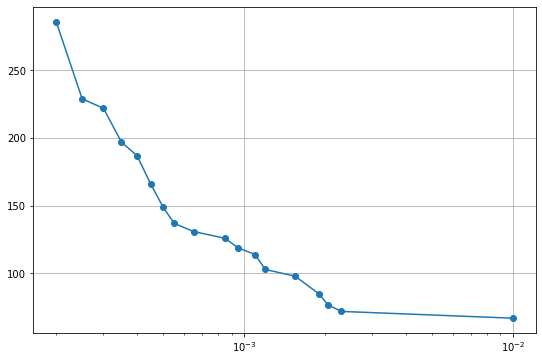

In [87]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x,y, 'o-')
ax.set_xscale('log')
ax.grid()

# Modify SRG file

In [7]:
import glob

In [43]:
network = 'italy_995'
g_init = read_lgf_to_networkx_extended(f'networks/{network}_initial.lgf')
g_spine = read_lgf_to_networkx_extended(f'networks/{network}.lgf')

srlg_adj_sample = sample(srlg_adj_nocut, int(len(srlg_adj)*0.1) )

for srg_file in glob.glob(f'results/{network}/SRLG/initial/*.srg'):
    g, srlgs = read_lgf_to_networkx_extended(srg_file)
    for i,e in list(enumerate(g.edges)):
    if i%2 == 1:
        g.remove_edge(*e)
    srlgs = [srlg[::2] for srlg in srlgs if len(srlg)>2]
    srlgs += srlg_simple_nocut + srlg_adj_sample
    
    #print(srlgs)
#     if '_S_' in srg_file:
#         write_networkx_to_srg(srg_file.replace('initial', 'initial+1.1'), g_spine, srlgs)
#     else:
#         write_networkx_to_srg(srg_file.replace('initial', 'initial+1.1'), g_init, srlgs)

In [36]:
for srlg in srlg_adj_sample:
    if not remains_connected(g_init.copy(), srlg):
        print(srlg)

[(17, 16), (17, 23)]
[(13, 11), (13, 14)]


# TFA, T connection

In [2]:
# The network
network = 'italy_995'

g = nx.read_gml(f'networks/{network}.gml', label="id")
L = len(g.edges)
links = range(L)

# The matrix of the intensity values, dimensions: [L,P,M] (link, position, magnitude)
I1 = np.load(f'intensities/{network}_ds16.npy')
#I2 = np.load('intensities/italy_ds16_csak.npy')

# The matrix of earthquake probabilities, dimensions: [P,M] (position, magnitude)
prob_matrix = pd.read_csv('earthquake_probabilities/italy_ds16.csv').drop(['Lat', 'Long'], axis=1).to_numpy()
P, M = prob_matrix.shape
epicenters = range(P)
magnitudes = range(M)

srlgs, srlg_probs = get_SRLGs(f'PSRLGs/{network}.xml')
H = np.ones(L) * 6.

with open (f'min_cut_SRLGs/{network}', 'rb') as fp:
    min_cut_srlgs = pickle.load(fp)

In [17]:
TFAs = []
min_Ts = []

for upgrade_file in sorted(glob.glob(f'results/{network}/upgrade_level/SB0/*.csv')):
    df_upgrade = pd.read_csv(upgrade_file)
    TFA = float(upgrade_file.split('TFA')[-1].split('_')[0])
    max_cut_prob = max([get_SRLG_probability(srlg,g,I1,df_upgrade['H (Heuristic 2)'].to_numpy(),prob_matrix) for srlg in min_cut_srlgs])
    print(f'{TFA} {max_cut_prob:.6f}')
    TFAs.append(TFA)
    min_Ts.append(max_cut_prob)

0.0005 0.000108
0.0006 0.000108
0.0007 0.000338
0.0008 0.000338
0.0009 0.000338
0.001 0.000338
0.002 0.000338
0.003 0.000383
0.004 0.000894
0.005 0.000894
0.006 0.000894
0.007 0.001595
0.008 0.001595
0.009 0.001595
0.01 0.001595


Text(0, 0.5, 'min T to not block')

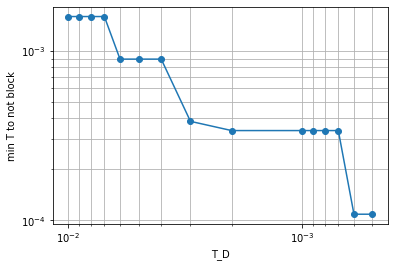

In [25]:
fig, ax = plt.subplots()
ax.loglog(TFAs, min_Ts, 'o-')
ax.invert_xaxis()
ax.grid(which='both')
ax.set_xlabel('T_D')
ax.set_ylabel('min T to not block')

In [7]:
cost = 0
for e in g.edges:
    cost += g.edges[e]['length']*g.edges[e]['onspine']
print(cost)

4324.1004253423
